In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%load_ext Cython
import warnings
warnings.filterwarnings('ignore')

In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
from py_unsio import *
import os
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter

In [3]:
%%cython -a 
from math import exp
import numpy as np

def triangularSum(int X):
    cdef int total=0
    for i in range(1,X):
        total = total + i
    return total
    

In [4]:
%%cython -a 
from math import exp
import numpy as np

def relative(double[:] X,size):
    cdef int N = X.shape[0]
    cdef double[:] Y = np.zeros(size)
    cdef int i, j
    cdef int cont = 0
    for i in range(N-1):
        for j in range(i+1,N):
            Y[cont] = (X[i]-X[j])**2
            cont = cont+1
    return np.array(Y)

In [5]:
hydro = wkbl.astro.halo_info.HALOBHydro()
simname=hydro.name
myhydro = wkbl.Galaxy_Hound(hydro.path)
print myhydro.dm.pos3d[:,0].max()
myhydro.center_shift(hydro.c_dm_com)
myhydro.r_virial(600,n=2)

loading Dark matter..
loading Stars..
loading Gas..
19878.004
| r_200 = 177.54
| Diagonal matrix computed 
|    | 20, 0, 0|
| D =| 0, 14, 0|
|    | 0,  0, 2|


In [6]:
limmin, limmax = 7.85,8.15
comp = 0
x = myhydro.dm.vel3d[(myhydro.dm.r>limmin)&((myhydro.dm.r<limmax)),0]
y = myhydro.dm.vel3d[(myhydro.dm.r>limmin)&((myhydro.dm.r<limmax)),1]
z = myhydro.dm.vel3d[(myhydro.dm.r>limmin)&((myhydro.dm.r<limmax)),2]

print "in the shell with {0} < r < {1} there are {2} particles ".format(limmin,limmax,x.shape[0])

in the shell with 7.85 < r < 8.15 there are 9812 particles 


In [7]:
#run the C rutine
x_rel = relative(x,triangularSum(len(x)))
print "x axis done"

y_rel = relative(y,triangularSum(len(y)))
print "y axis done"

z_rel = relative(z,triangularSum(len(z)))
print "z axis done"

x axis done
y axis done
z axis done


In [8]:
v_rel = np.array(x_rel+y_rel+ z_rel, dtype=np.float64)
v_rel = np.sqrt(v_rel)

In [9]:

endR = 2*myhydro.r200
in_halo = np.where((myhydro.dm.r>1.)&(myhydro.dm.r<endR))#&((myhydro.dm.r>2.*myhydro.gs.hsml)))
sorted_r = np.argsort(myhydro.dm.r[in_halo])
part_per_bin = 15000
N_total = len(myhydro.dm.mass[in_halo])
bins_index = sorted_r[np.linspace(0,N_total-1,N_total/part_per_bin,dtype=int)]
bins_in_r = (myhydro.dm.r[in_halo])[bins_index]

In [10]:
v_m2 = v_m1 = v = v2 = np.array([]) 
std_m2 = std_m1 = std = std2 = np.array([]) 

for i in range(len(bins_in_r)-1):
    limmin, limmax = bins_in_r[i],bins_in_r[i+1]
    x = myhydro.dm.vel3d[(myhydro.dm.r>limmin)&((myhydro.dm.r<limmax)),0]
    y = myhydro.dm.vel3d[(myhydro.dm.r>limmin)&((myhydro.dm.r<limmax)),1]
    z = myhydro.dm.vel3d[(myhydro.dm.r>limmin)&((myhydro.dm.r<limmax)),2]
    if i%100==0:print "in the shell with {0} < r < {1}".format(limmin,limmax,x.shape[0])
    x_rel = relative(x,triangularSum(len(x)))
    y_rel = relative(y,triangularSum(len(y)))
    z_rel = relative(z,triangularSum(len(z)))
    v_rel = np.array(x_rel+y_rel+ z_rel, dtype=np.float64)
    v_m2 = np.append(v_m2,np.mean(1./v_rel))
    std_m2 = np.append(std_m2,np.std(1./v_rel))
    v2 = np.append(v2,np.mean(v_rel))
    std2 = np.append(std2,np.std(v_rel))
    v_rel = np.sqrt(v_rel)
    v = np.append(v,np.mean(v_rel))
    std = np.append(std,np.std(v_rel))
    v_m1 = np.append(v_m1,np.mean(1./v_rel))
    std_m1 = np.append(std_m1,np.std(1./v_rel))


    
    


in the shell with 1.00076704117 < r < 2.69156122331
in the shell with 102.101222732 < r < 103.724745808


In [11]:
hydro.namenospace

'HALOB'

In [12]:
patho = "/home/arturo/Documents/LAM/LAM2LUPM/relative_speed/"+hydro.namenospace
v_2_av = np.loadtxt(patho+'/Eddington/v_rel_2_minus_2_Eddington_'+hydro.namenospace+'_'+hydro.version+'.txt')
v_1_av = np.loadtxt(patho+'/Eddington/v_rel_2_minus_1_Eddington_'+hydro.namenospace+'_'+hydro.version+'.txt')
v_av = np.loadtxt(patho+'/Eddington/v_rel_Eddington_'+hydro.namenospace+'_'+hydro.version+'.txt')
v2_av = np.loadtxt(patho+'/Eddington/v_rel_sqr_Eddington_'+hydro.namenospace+'_'+hydro.version+'.txt')



In [13]:
patho = "/home/arturo/Documents/LAM/LAM2LUPM/relative_speed/"+hydro.namenospace
v_2_av_m = np.loadtxt(patho+'/Maxwellian/v_rel_2_minus_2_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')
v_1_av_m = np.loadtxt(patho+'/Maxwellian/v_rel_2_minus_1_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')
v_av_m = np.loadtxt(patho+'/Maxwellian/v_rel_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')
v2_av_m = np.loadtxt(patho+'/Maxwellian/v_rel_sqr_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')


In [14]:
patho = "/home/arturo/Documents/LAM/LAM2LUPM/relative_speed/"+hydro.namenospace
v_2_av_Tm = np.loadtxt(patho+'/truncated_Maxwellian/v_rel_2_minus_2_truncated_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')
v_1_av_Tm = np.loadtxt(patho+'/truncated_Maxwellian/v_rel_2_minus_1_truncated_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')
v_av_Tm = np.loadtxt(patho+'/truncated_Maxwellian/v_rel_truncated_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')
v2_av_Tm = np.loadtxt(patho+'/truncated_Maxwellian/v_rel_sqr_truncated_Maxwellian_'+hydro.namenospace+'_'+hydro.version+'.txt')


<IPython.core.display.Javascript object>


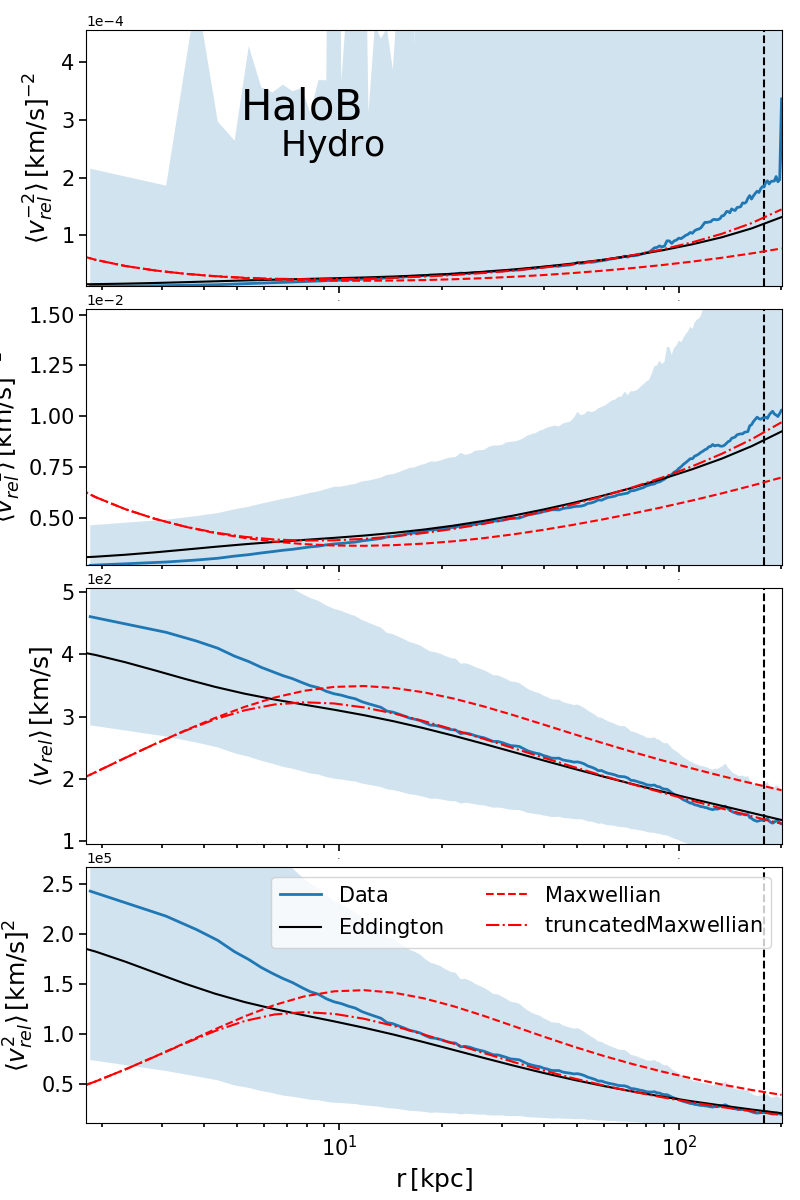

In [15]:
fig, ax = plt.subplots(4,1,figsize=[8,12])
ax[0].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[1].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[2].yaxis.get_major_formatter().set_powerlimits((0, 2))
ax[3].yaxis.get_major_formatter().set_powerlimits((0, 2))


ax[3].set_xlabel(r'$\rm r \,[kpc]$',fontsize=18)
ax[0].set_ylabel(r'$\langle v_{rel}^{-2} \rangle$$\rm \, [km/s]^{-2}$',fontsize=18)
ax[1].set_ylabel(r'$\langle v_{rel}^{-1} \rangle$$\rm \,[km/s]^{-1}$',fontsize=18)
ax[2].set_ylabel(r'$\langle v_{rel} \rangle$$\rm \,[km/s]$',fontsize=18)
ax[3].set_ylabel(r'$\langle v_{rel}^{2} \rangle$$\rm \,[km/s]^2$',fontsize=18)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')

ax[0].set_ylim([np.nanmin(v_m2),1.1*np.nanmax(v_m2)])
ax[1].set_ylim([np.nanmin(v_m1),1.1*np.nanmax(v_m1)])
ax[2].set_ylim([np.nanmin(v),1.1*np.nanmax(v)])
ax[3].set_ylim([np.nanmin(v2),1.1*np.nanmax(v2)])



ax[0].set_xlim([1.8,v_2_av[:,0].max()])
ax[1].set_xlim([1.8,v_av[:,0].max()])
ax[2].set_xlim([1.8,v_av[:,0].max()])
ax[3].set_xlim([1.8,v_av[:,0].max()])

ax[0].axvline(x=myhydro.r200,color='k',linestyle='--')
ax[1].axvline(x=myhydro.r200,color='k',linestyle='--')
ax[2].axvline(x=myhydro.r200,color='k',linestyle='--')
ax[3].axvline(x=myhydro.r200,color='k',linestyle='--')


alpha=0.2
font=15
r_v_c = (bins_in_r[1:] + bins_in_r[:-1])/2.
ax[0].plot(r_v_c,v_m2,lw=2)
ax[0].fill_between(r_v_c,v_m2-std_m2,v_m2+std_m2,alpha=alpha)
ax[0].plot(v_2_av[:,0],v_2_av[:,1],"k",lw=1.5)

ax[0].plot(v_2_av_m[:,0],v_2_av_m[:,1],"r--",lw=1.5)
ax[0].plot(v_2_av_Tm[:,0],v_2_av_Tm[:,1],"r-.",lw=1.5)

fig.text(0.3,.9,r"$\rm"+ hydro.name +" $",fontsize=30)
fig.text(0.35,.87,r"$\rm Hydro $",fontsize=25)


ax[1].plot(r_v_c,v_m1,lw=2)
ax[1].fill_between(r_v_c,v_m1-std_m1,v_m1+std_m1,alpha=alpha)

ax[1].plot(v_1_av[:,0],v_1_av[:,1],"k",lw=1.5)
ax[1].plot(v_1_av_m[:,0],v_1_av_m[:,1],"r--",lw=1.5)
ax[1].plot(v_1_av_Tm[:,0],v_1_av_Tm[:,1],"r-.",lw=1.5)

ax[2].plot(r_v_c,v,lw=2)
ax[2].fill_between(r_v_c,v-std,v+std,alpha=alpha)

ax[2].plot(v_av[:,0],v_av[:,1],"k",lw=1.5)
ax[2].plot(v_av_m[:,0],v_av_m[:,1],"r--",lw=1.5)
ax[2].plot(v_av_Tm[:,0],v_av_Tm[:,1],"r-.",lw=1.5)

ax[3].plot(r_v_c,v2,lw=2,label=r"$\rm Data$")
ax[3].fill_between(r_v_c,v2-std2,v2+std2,alpha=alpha)


ax[3].plot(v2_av[:,0],v2_av[:,1],"k",lw=1.5,label=r"$\rm Eddington$")
ax[3].plot(v2_av_m[:,0],v2_av_m[:,1],"r--",lw=1.5,label=r"$\rm Maxwellian$")
ax[3].plot(v2_av_Tm[:,0],v2_av_Tm[:,1],"r-.",lw=1.5,label=r"$\rm truncated Maxwellian$")
legend = ax[3].legend(loc='upper right', ncol=2, shadow=False, fontsize=font)
frame = legend.get_frame()

fig.tight_layout(h_pad=-1.5)
ax[2].text(170,1e7,r'R$_{200}$',fontsize=17)


ax[0].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[2].tick_params(axis='y', which='major', labelsize=15, size=5,width=1.2)
ax[2].tick_params(axis='x', which='major', labelsize=0, size=5,width=1.2)
ax[2].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[3].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[3].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/VdfComparison/v_rel_moments_"+hydro.namenospace+"_"+hydro.version+".pdf",dpi=300)
